In [4]:
# Comparing fiTQun's results with the fully supervised ResNet-18 classifier on the varying position dataset

# Naming convention: first particle type is which file it is from, last particletype is what the hypothesis is

(1118723,)


In [1]:
## Imports

import sys
import os
import time
import math
import random
import pdb
import h5py

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
# Plotting import
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import the utils for plotting the metrics
from plot_utils import plot_utils
from plot_utils import notebook_utils_2

from sklearn.metrics import roc_curve, auc

In [28]:
# Fix the colour scheme for each particle type
COLOR_DICT = {"gamma":"red", "e":"blue", "mu":"green"}

In [29]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [30]:
# Plot multiple ROC curves on the same figure
def plot_multiple_ROC(fprs, tprs, thresholds, label_0, label_1, lbound, ubound, interval):
    
    min_energy = 0
    max_energy = 1000
    
    fig, ax = plt.subplots(figsize=(16,9),facecolor="w")
    ax.tick_params(axis="both", labelsize=20)
    
    model_colors = [np.random.rand(3,) for i in fprs]
    
    for j in np.arange(len(fprs)):
        fpr = fprs[j]
        tpr = tprs[j]
        threshold = thresholds[j]
     
        roc_auc = auc(fpr, tpr)

        inv_fpr = []
        for i in fpr:
            inv_fpr.append(1/i) if i != 0 else inv_fpr.append(1/1e-5)

        tnr = 1. - fpr

        # TNR vs TPR plot

        ax.plot(tpr, inv_fpr, color=model_colors[j],
                 label=r"Interval ${1:0.3f}$: $\{0}$, AUC ${1:0.3f}$".format((j+1),label_0, roc_auc) if label_0 is not "e" else r"${0}$, AUC ${1:0.3f}$".format(label_0, roc_auc),
                 linewidth=1.0, marker=".", markersize=4.0, markerfacecolor=model_colors[j])

        # Show coords of individual points near x = 0.2, 0.5, 0.8
        todo = {0.2: True, 0.5: True, 0.8: True}
        for xy in zip(tpr, inv_fpr, tnr):
            xy = (round(xy[0], 4), round(xy[1], 4), round(xy[2], 4))
            xy_plot = (round(xy[0], 4), round(xy[1], 4))
            for point in todo.keys():
                if xy[0] >= point and todo[point]:
                    #ax.annotate('(%s, %s, %s)' % xy, xy=xy_plot, textcoords='data', fontsize=18, bbox=dict(boxstyle="square", fc="w"))
                    todo[point] = False

            ax.grid(True, which='both', color='grey')
            xlabel = r"$\{0}$ signal efficiency".format(label_0) if label_0 is not "e" else r"${0}$ signal efficiency".format(label_0)
            ylabel = r"$\{0}$ background rejection".format(label_1) if label_1 is not "e" else r"${0}$ background rejection".format(label_1)

            ax.set_xlabel(xlabel, fontsize=20) 
            ax.set_ylabel(ylabel, fontsize=20)

            ax.set_title(r"${0} \leq E < {1}$".format(round(lbound,2), round(ubound,2)), fontsize=20)
            ax.legend(loc="upper right", prop={"size":20})

            plt.margins(0.1)
        plt.yscale("log")
        
    plt.savefig(('/home/ttuinstr/VAE/debugging/ROC_' + str(interval) + '.png'), bbox_inches='tight')    
    
    plt.show()

    plt.clf() # Clear the current figure
    plt.close() # Close the opened window
        
        
    return fpr, tpr, threshold, roc_auc

In [53]:
def plot_rej_energy(fprs, tprs, thresholds, label_0, label_1, lbound, ubound, interval, efficiency, bins, colour):
    
    min_energy = 0
    max_energy = 1000
    
    fig, ax = plt.subplots(figsize=(16,9),facecolor="w")
    ax.tick_params(axis="both", labelsize=20)
    
    model_colors = [np.random.rand(3,) for i in fprs]
    
    eff_invfpr = np.array([])
    
    error = []
    
    for j in np.arange(len(fprs)):
        fpr = fprs[j]
        tpr = tprs[j]
        threshold = thresholds[j]
     
        roc_auc = auc(fpr, tpr)

        inv_fpr = np.array([])
        for i in fpr:
            if i != 0:
                inv_fpr = np.append(inv_fpr, (1/i))
            else:
                inv_fpr = np.append(inv_fpr, (1/1e-5))

        tnr = 1. - fpr
        
        eff_index = np.where(np.around(tpr, decimals=2) == 0.8)[0].astype(int)
        eff_invfpr = np.append(eff_invfpr, inv_fpr[eff_index].mean())
        error.append(inv_fpr[eff_index].std())
        
    # TNR vs Energy bin plot
    
    label = 0
    ax.bar(bins, height=eff_invfpr, yerr=error, width=interval, color=colour, align='edge')
    ax.legend()
    ax.set_ylabel("Background rejection", fontsize=20)

    plt.xlabel("Energy (MeV)", fontsize=20)
    
    plt.ylim(top=10**5)
    
    ax.set_title("Rejection vs. Energy Level at " + str(efficiency) + " Efficiency", fontsize=20)
    
    plt.yscale("log")
        
    plt.savefig(('/home/ttuinstr/VAE/debugging/RejectionEnergyBinning_' + str(efficiency) + "_" +  str(interval) + '.png'), bbox_inches='tight')    
    
    plt.show()

    plt.clf() # Clear the current figure
    plt.close() # Close the opened window
        
        
    return eff_invfpr, threshold, roc_auc

In [33]:
# Import test events from h5 file
filtered_index = "/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz"
filtered_indices = np.load(filtered_index, allow_pickle=True)
test_filtered_indices = filtered_indices['test_idxs']

original_data_path = "/data/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M.h5"
f = h5py.File(original_data_path, "r")
original_eventids = np.array(f['event_ids'])
original_rootfiles = np.array(f['root_files'])
original_energies = np.array(f['energies'])
original_positions = np.array(f['positions'])
original_angles = np.array(f['angles'])
filtered_eventids = original_eventids[test_filtered_indices]
filtered_rootfiles = original_rootfiles[test_filtered_indices]
filtered_energies = original_energies[test_filtered_indices]
filtered_positions = original_positions[test_filtered_indices]
filtered_angles = original_angles[test_filtered_indices]

# Map test events to fiTQun events

# Map ResNet results to fiTQun events

# Map ResNet results to original h5 file events
mapping_indices = np.load('/home/ttuinstr/VAE/debugging/map_indices_resnet.npz')
mapping_indices = mapping_indices['arr_0'].astype(int)

res_softmaxes = np.load('/home/ttuinstr/VAE/debugging/resnet_softmaxes.npz')
res_softmaxes = res_softmaxes['arr_0']
res_energies = np.load('/home/ttuinstr/VAE/debugging/resnet_energies.npz')
res_energies = res_energies['arr_0']
res_predictedlabels = np.load('/home/ttuinstr/VAE/debugging/resnet_predictedlabels.npz')
res_predictedlabels = res_predictedlabels['arr_0']

res_softmaxes = res_softmaxes[mapping_indices]
res_energies = res_energies[mapping_indices]
res_predictedlabels = res_predictedlabels[mapping_indices]

# Separate event types
e_test_indices = np.load('/home/ttuinstr/VAE/debugging/test_indices_e.npz')
e_test_indices = e_test_indices['arr_0'].astype(int)
mu_test_indices = np.load('/home/ttuinstr/VAE/debugging/test_indices_mu.npz')
mu_test_indices = mu_test_indices['arr_0'].astype(int)
gamma_test_indices = np.load('/home/ttuinstr/VAE/debugging/test_indices_gamma.npz')
gamma_test_indices = gamma_test_indices['arr_0'].astype(int)

e_predictedlabels = res_predictedlabels[e_test_indices]
mu_predictedlabels = res_predictedlabels[mu_test_indices]
gamma_predictedlabels = res_predictedlabels[gamma_test_indices]

e_softmaxes = res_softmaxes[e_test_indices]
mu_softmaxes = res_softmaxes[mu_test_indices]
gamma_softmaxes = res_softmaxes[gamma_test_indices]

e_labels = filtered_labels[e_test_indices]
mu_labels = filtered_labels[mu_test_indices]
gamma_labels = filtered_labels[gamma_test_indices]

e_rootfiles = filtered_rootfiles[e_test_indices]
mu_rootfiles = filtered_rootfiles[mu_test_indices]
gamma_rootfiles = filtered_rootfiles[gamma_test_indices]

e_eventids = filtered_eventids[e_test_indices]
mu_eventids = filtered_eventids[mu_test_indices]
gamma_eventids = filtered_eventids[gamma_test_indices]

e_positions = filtered_positions[e_test_indices]
mu_positions = filtered_positions[mu_test_indices]
gamma_positions = filtered_positions[gamma_test_indices]

e_angles = filtered_angles[e_test_indices]
mu_angles = filtered_angles[mu_test_indices]
gamma_angles = filtered_angles[gamma_test_indices]

e_energies = filtered_energies[e_test_indices]
mu_energies = filtered_energies[mu_test_indices]
gamma_energies = filtered_energies[gamma_test_indices]

# Match events in event types to fiTQun results
e_map_indices = np.load('/home/ttuinstr/VAE/debugging/map_indices_e_all.npz')
e_map_indices = e_map_indices['arr_0'].astype(int)
mu_map_indices = np.load('/home/ttuinstr/VAE/debugging/map_indices_mu_all.npz')
mu_map_indices = mu_map_indices['arr_0'].astype(int)
gamma_map_indices = np.load('/home/ttuinstr/VAE/debugging/map_indices_gamma_all.npz')
gamma_map_indices = gamma_map_indices['arr_0'].astype(int)

#e_eventdata = np.sum(original_eventdata[test_filtered_indices][e_test_indices][e_map_indices] > 0, (1,2,3))
#mu_eventdata = np.sum(original_eventdata[test_filtered_indices][mu_test_indices][mu_map_indices] > 0, (1,2,3))
#gamma_eventdata = np.sum(original_eventdata[test_filtered_indices][gamma_test_indices][gamma_map_indices] > 0, (1,2,3))

e_predictedlabels = e_predictedlabels[e_map_indices]
mu_predictedlabels = mu_predictedlabels[mu_map_indices]
gamma_predictedlabels = gamma_predictedlabels[gamma_map_indices]

e_softmaxes = e_softmaxes[e_map_indices]
mu_softmaxes = mu_softmaxes[mu_map_indices]
gamma_softmaxes = gamma_softmaxes[gamma_map_indices]

e_labels = e_labels[e_map_indices]
mu_labels = mu_labels[mu_map_indices]
gamma_labels = gamma_labels[gamma_map_indices]

e_positions = e_positions[e_map_indices]
mu_positions = mu_positions[mu_map_indices]
gamma_positions = gamma_positions[gamma_map_indices]

e_angles = e_angles[e_map_indices]
mu_angles = mu_angles[mu_map_indices]
gamma_angles = gamma_angles[gamma_map_indices]

e_energies = e_energies[e_map_indices]
mu_energies = mu_energies[mu_map_indices]
gamma_energies = gamma_energies[gamma_map_indices]

# For making ROC curves
e_softmax_0 = e_softmaxes[e_labels==softmax_index_dict[label_0]] 
mu_softmax_0 = mu_softmaxes[mu_labels==softmax_index_dict[label_0]]
gamma_softmax_0 = gamma_softmaxes[gamma_labels==softmax_index_dict[label_0]]

e_labels_0 = e_labels[e_labels==softmax_index_dict[label_0]] 
mu_labels_0 = mu_labels[mu_labels==softmax_index_dict[label_0]]
gamma_labels_0 = gamma_labels[gamma_labels==softmax_index_dict[label_0]]

e_softmax_1 = e_softmaxes[e_labels==softmax_index_dict[label_1]] 
mu_softmax_1 = mu_softmaxes[mu_labels==softmax_index_dict[label_1]]
gamma_softmax_1 = gamma_softmaxes[gamma_labels==softmax_index_dict[label_1]]

e_labels_1 = e_labels[e_labels==softmax_index_dict[label_1]] 
mu_labels_1 = mu_labels[mu_labels==softmax_index_dict[label_1]]
gamma_labels_1 = gamma_labels[gamma_labels==softmax_index_dict[label_1]]

total_softmax = np.concatenate((e_softmax_0, e_softmax_1, mu_softmax_0, mu_softmax_1), axis=0)
total_labels = np.concatenate((e_labels_0, e_labels_1, mu_labels_0, mu_labels_1), axis=0)


res_fpr, res_tpr, res_threshold = roc_curve(total_labels, total_softmax[:,softmax_index_dict[label_0]], pos_label=softmax_index_dict[label_0])

In [36]:
# Load the fiTQun results

# File paths for fiTQun results
fiTQun_e_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_e-.npz"
fiTQun_mu_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_mu-.npz"
fiTQun_gamma_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_gamma.npz"

# Load fiTQun results
f_e = np.load(fiTQun_e_path, allow_pickle=True)
f_mu = np.load(fiTQun_mu_path, allow_pickle=True)
f_gamma = np.load(fiTQun_gamma_path, allow_pickle=True)

list(f_e.keys())

# Remove events with a non-zero flag (this filtering will be applied to the other results as well)
# * A non-zero flag value usually implies that either the reconstruction is known to have failed 
#   or the particle exited the tank and so would not be included in actual physics analysis
e_flag = np.array(f_e['flag'])
#e_indices = np.where((e_flag[:,0] == 0) & (e_flag[:,1] == 0))
e_flagindices = np.where((e_flag[:,0] != 0) | (e_flag[:,1] != 0))
mu_flag = np.array(f_mu['flag'])
#mu_indices = np.where((mu_flag[:,0] == 0) & (mu_flag[:,1] == 0))
mu_flagindices = np.where((mu_flag[:,0] != 0) | (mu_flag[:,1] != 0))
gamma_flag = np.array(f_gamma['flag'])
#gamma_indices = np.where((gamma_flag[:,0] == 0) & (gamma_flag[:,1] == 0))
gamma_flagindices = np.where((gamma_flag[:,0] != 0) | (gamma_flag[:,1] != 0))

# Get the filename for each event
e_file = np.array(f_e['filename'])
#e_file = e_file[e_indices]
mu_file = np.array(f_mu['filename'])
#mu_file = mu_file[mu_indices]
gamma_file = np.array(f_gamma['filename'])
#gamma_file = gamma_file[gamma_indices]

# Get the event ID for each event
e_eventid = np.array(f_e['eventid'])
#e_eventid = e_eventid[e_indices]
mu_eventid = np.array(f_mu['eventid'])
#mu_eventid = mu_eventid[mu_indices]
gamma_eventid = np.array(f_gamma['eventid'])
#gamma_eventid = gamma_eventid[gamma_indices]

# Get the nLL for each event
# The first nLL value is for electron hypothesis and second nLL is for the muon hypothesis
e_nLL = np.array(f_e['nLL'])
#e_nLL = e_nLL[e_indices]
mu_nLL = np.array(f_mu['nLL'])
#mu_nLL = mu_nLL[mu_indices]
gamma_nLL = np.array(f_gamma['nLL'])
#gamma_nLL = gamma_nLL[gamma_indices]

# Get the position for each event
e_dir = np.array(f_e['direction'])
#e_dir = e_dir[e_indices]
mu_dir = np.array(f_mu['direction'])
#mu_dir = mu_dir[mu_indices]
gamma_dir = np.array(f_gamma['direction'])
#gamma_dir = gamma_dir[gamma_indices]

# Get the direction for each event
e_pos = np.array(f_e['position'])
#e_pos = e_pos[e_indices]
mu_pos = np.array(f_mu['position'])
#mu_pos = mu_pos[mu_indices]
gamma_pos = np.array(f_gamma['position'])
#gamma_pos = gamma_pos[gamma_indices]

# Get the momentum for each event
e_mom = np.array(f_e['momentum'])
#e_mom = e_mom[e_indices]
mu_mom = np.array(f_mu['momentum'])
#mu_mom = mu_mom[mu_indices]
gamma_mom = np.array(f_gamma['momentum'])
#gamma_mom = gamma_mom[gamma_indices]

# Get the time for each event
e_time = np.array(f_e['time'])
#e_time = e_time[e_indices]
mu_time = np.array(f_mu['time'])
#mu_time = mu_time[mu_indices]
gamma_time = np.array(f_gamma['time'])
#gamma_time = gamma_time[gamma_indices]

In [37]:
# Find the raw nLL differences

# nLL differences
e_nLL_diff_e = e_nLL[:,1] - e_nLL[:,0]
mu_nLL_diff_e = mu_nLL[:,1] - mu_nLL[:,0]
gamma_nLL_diff_e = gamma_nLL[:,1] - gamma_nLL[:,0]

e_nLL_diff_mu = e_nLL[:,0] - e_nLL[:,1]
mu_nLL_diff_mu = mu_nLL[:,0] - mu_nLL[:,1]
gamma_nLL_diff_mu = gamma_nLL[:,0] - gamma_nLL[:,1]

# labels
e_labels_mu = np.zeros(e_nLL_diff_mu.shape)
mu_labels_mu = np.ones(mu_nLL_diff_mu.shape)
e_labels_e = np.ones(e_nLL_diff_e.shape)
mu_labels_e = np.zeros(mu_nLL_diff_e.shape)

# concatenate labels and differences from mu and e events
diff_mu = np.concatenate((mu_nLL_diff_mu, e_nLL_diff_mu), axis=0)
labels_mu = np.concatenate((mu_labels_mu, e_labels_mu), axis=0)
diff_e = np.concatenate((mu_nLL_diff_e, e_nLL_diff_e), axis=0)
labels_e = np.concatenate((mu_labels_e, e_labels_e), axis=0)

In [38]:
# Make e vs. mu ROC curve for raw nLL differences 
#fpr, tpr, threshold = roc_curve(labels_e, diff_e)
#roc_metrics = plot_ROC(fpr, tpr, threshold, "e", "mu", 0, 1000)

In [41]:
# Take slices of events based on interval size for (reconstructed) energy - ELECTRONS

diff_e_slices = []
labels_e_slices = []

e_nLL_diff_e_slices = []
mu_nLL_diff_e_slices = []

e_mom_slices = []
mu_mom_slices = []

interval = 50
print(int(1000/interval))

for i in np.arange(int(1000/interval)):
    
    lb = i*interval
    ub = (i+1)*interval
    
    e_nLL_slice = e_nLL[np.where(((e_mom[:,0] >lb) & (e_mom[:,0] <ub)))[0],:]
    mu_nLL_slice = mu_nLL[np.where(((mu_mom[:,0] >lb) & (mu_mom[:,0] <ub)))[0],:]
    
    e_mom_slices.append(e_mom[np.where(((e_mom[:,0] >lb) & (e_mom[:,0] <ub)))[0],:])
    mu_mom_slices.append(mu_mom[np.where(((mu_mom[:,0] >lb) & (mu_mom[:,0] <ub)))[0],:])
    
    e_nLL_diff_e_slices.append(e_nLL_slice[:,1] - e_nLL_slice[:,0])
    mu_nLL_diff_e_slices.append(mu_nLL_slice[:,1] - mu_nLL_slice[:,0])

    e_labels_e_slice = np.ones(e_nLL_diff_e_slices[i].shape)
    mu_labels_e_slice = np.zeros(mu_nLL_diff_e_slices[i].shape)

    diff_e_slices.append(np.concatenate((mu_nLL_diff_e_slices[i], e_nLL_diff_e_slices[i]), axis=0))
    labels_e_slices.append(np.concatenate((mu_labels_e_slice, e_labels_e_slice), axis=0))

20


In [42]:
# Take slices of events based on interval size for (true) energy - ELECTRONS

diff_e_slices = []
labels_e_slices = []

e_nLL_diff_e_slices = []
mu_nLL_diff_e_slices = []

e_mom_slices = []
mu_mom_slices = []

interval = 50
print(int(1000/interval))

for i in np.arange(int(1000/interval)):
    
    lb = i*interval
    ub = (i+1)*interval
    
    e_nLL_slice = e_nLL[np.where(((e_energies[:,0] >lb) & (e_energies[:,0] <ub)))[0],:]
    mu_nLL_slice = mu_nLL[np.where(((mu_energies[:,0] >lb) & (mu_energies[:,0] <ub)))[0],:]
    
    e_mom_slices.append(e_mom[np.where(((e_energies[:,0] >lb) & (e_energies[:,0] <ub)))[0],:])
    mu_mom_slices.append(mu_mom[np.where(((mu_energies[:,0] >lb) & (mu_energies[:,0] <ub)))[0],:])
    
    e_nLL_diff_e_slices.append(e_nLL_slice[:,1] - e_nLL_slice[:,0])
    mu_nLL_diff_e_slices.append(mu_nLL_slice[:,1] - mu_nLL_slice[:,0])

    e_labels_e_slice = np.ones(e_nLL_diff_e_slices[i].shape)
    mu_labels_e_slice = np.zeros(mu_nLL_diff_e_slices[i].shape)

    diff_e_slices.append(np.concatenate((mu_nLL_diff_e_slices[i], e_nLL_diff_e_slices[i]), axis=0))
    labels_e_slices.append(np.concatenate((mu_labels_e_slice, e_labels_e_slice), axis=0))

20


In [44]:
# Make and plot ROC curves of event slices on same figure
#fpr, tpr, threshold = roc_curve(labels_e_slice, diff_e_slice)
#roc_metrics = plot_ROC(fpr, tpr, threshold, "e", "mu", lb, ub)
fprs = []
tprs = []
thresholds = []
for i in np.arange(20):
    fpr, tpr, threshold = roc_curve(labels_e_slices[i], diff_e_slices[i])
    fprs.append(fpr)
    tprs.append(tpr)
    thresholds.append(threshold)
    
#roc_metrics = plot_multiple_ROC(fprs, tprs, thresholds, "e", "mu", 0, 1000, 50)

20
[0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950]


No handles with labels found to put in legend.


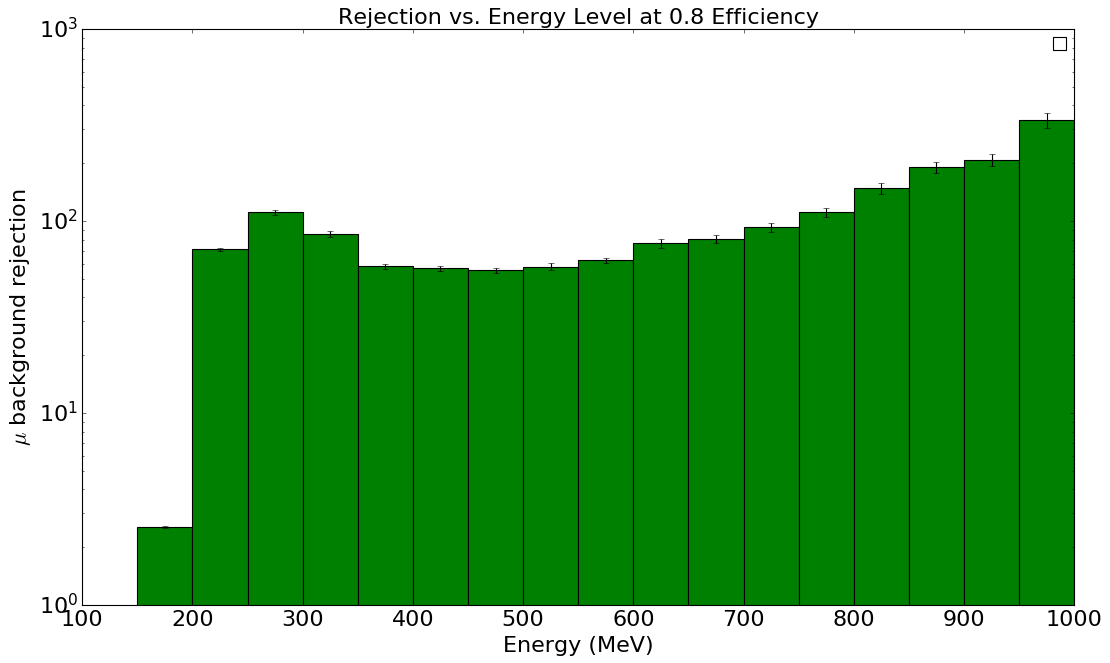

In [45]:
# Make and plot rejection vs. energy bin with fixed efficiency
efficiency = 0.8
fprs = []
tprs = []
thresholds = []

for i in np.arange(len(labels_e_slices)):
    fpr, tpr, threshold = roc_curve(labels_e_slices[i], diff_e_slices[i])
    fprs.append(fpr)
    tprs.append(tpr)
    thresholds.append(threshold)
    
# Set up the bins for the histogram 
bins = []
for i in np.arange(len(fprs)):
    bins.append(i*interval)
print(len(bins))
print(bins)
    
curve_metrics = plot_rej_energy(fprs, tprs, thresholds, "e", "mu", 0, 1000, 50, efficiency, bins, "green")

In [51]:
# Take slices of events based on interval size for (reconstructed) energy - MUONS

diff_mu_slices = []
labels_mu_slices = []

e_nLL_diff_mu_slices = []
mu_nLL_diff_mu_slices = []

e_mom_slices = []
mu_mom_slices = []

interval = 50
print(int(1000/interval))

for i in np.arange(int(1000/interval)):
    
    lb = i*interval + 160
    ub = (i+1)*interval + 160
    
    e_nLL_slice = e_nLL[np.where(((e_mom[:,1] >lb) & (e_mom[:,1] <ub)))[0],:]
    mu_nLL_slice = mu_nLL[np.where(((mu_mom[:,1] >lb) & (mu_mom[:,1] <ub)))[0],:]
    
    e_mom_slices.append(e_mom[np.where(((e_mom[:,1] >lb) & (e_mom[:,1] <ub)))[0],:])
    mu_mom_slices.append(mu_mom[np.where(((mu_mom[:,1] >lb) & (mu_mom[:,1] <ub)))[0],:])
    
    e_nLL_diff_mu_slices.append(e_nLL_slice[:,0] - e_nLL_slice[:,1])
    mu_nLL_diff_mu_slices.append(mu_nLL_slice[:,0] - mu_nLL_slice[:,1])

    e_labels_mu_slice = np.zeros(e_nLL_diff_mu_slices[i].shape)
    mu_labels_mu_slice = np.ones(mu_nLL_diff_mu_slices[i].shape)
    
    diff_mu_slices.append(np.concatenate((mu_nLL_diff_mu_slices[i], e_nLL_diff_mu_slices[i]), axis=0))
    labels_mu_slices.append(np.concatenate((mu_labels_mu_slice, e_labels_mu_slice), axis=0))

20


In [55]:
# Take slices of events based on interval size for (true) energy - MUONS

diff_mu_slices = []
labels_mu_slices = []

e_nLL_diff_mu_slices = []
mu_nLL_diff_mu_slices = []

e_mom_slices = []
mu_mom_slices = []

interval = 50
print(int(1000/interval))

for i in np.arange(int(1000/interval)):
    
    lb = i*interval
    ub = (i+1)*interval
    
    e_nLL_slice = e_nLL[np.where(((e_energies[:,0] >lb) & (e_energies[:,0] <ub)))[0],:]
    mu_nLL_slice = mu_nLL[np.where(((mu_energies[:,0] >lb) & (mu_energies[:,0] <ub)))[0],:]
    
    e_mom_slices.append(e_mom[np.where(((e_energies[:,0] >lb) & (e_energies[:,0] <ub)))[0],:])
    mu_mom_slices.append(mu_mom[np.where(((mu_energies[:,0] >lb) & (mu_energies[:,0] <ub)))[0],:])
    
    e_nLL_diff_mu_slices.append(e_nLL_slice[:,0] - e_nLL_slice[:,1])
    mu_nLL_diff_mu_slices.append(mu_nLL_slice[:,0] - mu_nLL_slice[:,1])
    
    e_labels_mu_slice = np.zeros(e_nLL_diff_mu_slices[i].shape)
    mu_labels_mu_slice = np.ones(mu_nLL_diff_mu_slices[i].shape)

    diff_mu_slices.append(np.concatenate((mu_nLL_diff_mu_slices[i], e_nLL_diff_mu_slices[i]), axis=0))
    labels_mu_slices.append(np.concatenate((mu_labels_mu_slice, e_labels_mu_slice), axis=0))

20


20
[0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice.
No handles with labels found to put in legend.


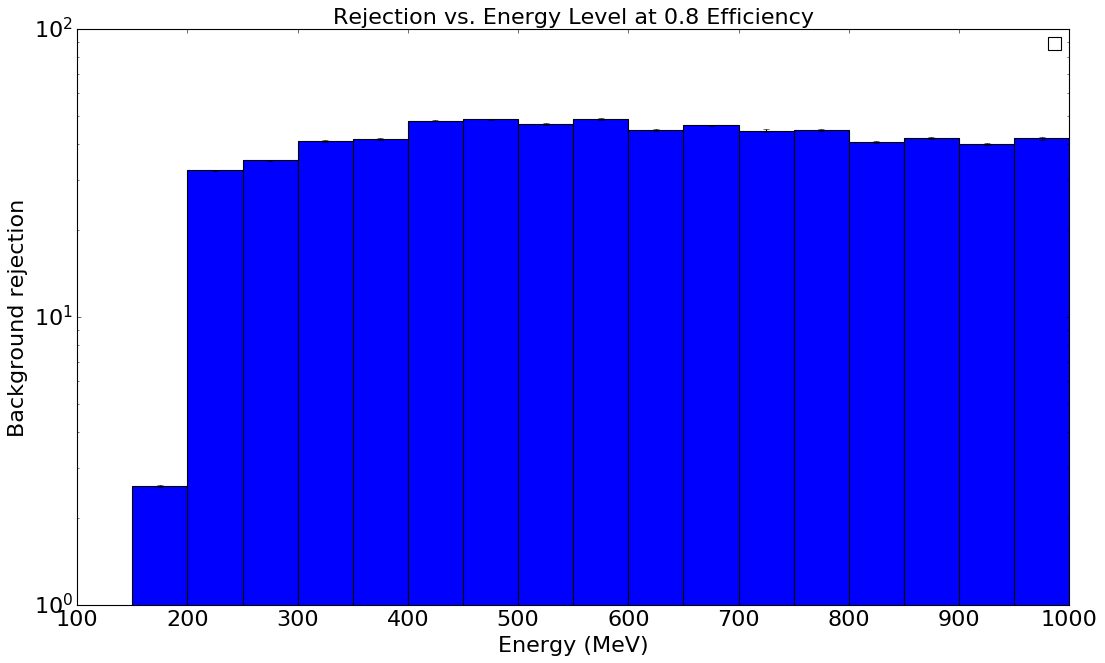

In [56]:
# Make and plot rejection vs. energy bin with fixed efficiency
efficiency = 0.8
fprs = []
tprs = []
thresholds = []

for i in np.arange(len(labels_mu_slices)):
    fpr, tpr, threshold = roc_curve(labels_mu_slices[i], diff_mu_slices[i])
    fprs.append(fpr)
    tprs.append(tpr)
    thresholds.append(threshold)
    
# Set up the bins for the histogram 
bins = []
for i in np.arange(len(fprs)):
    bins.append(i*interval)
print(len(bins))
print(bins)
    
curve_metrics = plot_rej_energy(fprs, tprs, thresholds, "mu", "e", 160, 1160, 50, efficiency, bins, "blue")

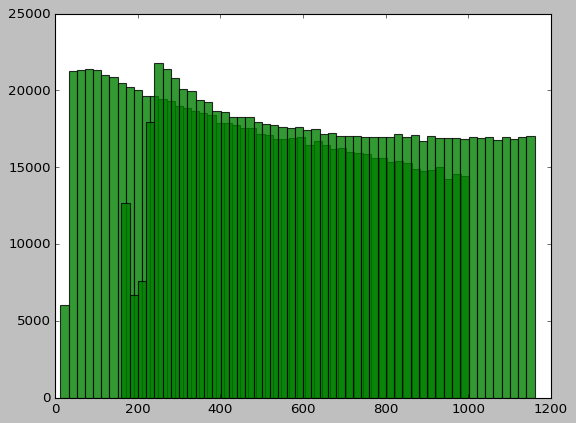

In [69]:
label_dict = {0:["gamma","red"], 1:["e","blue"], 2:["mu","green"]}

e_H, e_edges, e_patches = plt.hist(e_energies, bins=50, density=False, label=label_dict[label + 1][0], alpha=0.8,
                 color=label_dict[label + 1][1])

e_weights = np.ones(e_mom.shape[0])

for i in np.arange(e_H.shape[0]):
    bin_indices = np.where((e_mom[:,0] >= e_edges[i]) & (e_mom[:,0] < e_edges[i+1]))[0]
    e_weights[bin_indices] = 1/e_H[i]

mu_H, mu_edges, mu_patches = plt.hist(mu_energies, bins=50, density=False, label=label_dict[label + 1][0], alpha=0.8,
                 color=label_dict[label + 1][1])

mu_weights = np.ones(mu_mom.shape[0])

for i in np.arange(mu_H.shape[0]):
    bin_indices = np.where((mu_mom[:,0] >= mu_edges[i]) & (mu_mom[:,0] < mu_edges[i+1]))[0]
    mu_weights[bin_indices] = 1/mu_H[i]

Text(0.5, 0, 'True Energy (MeV)')

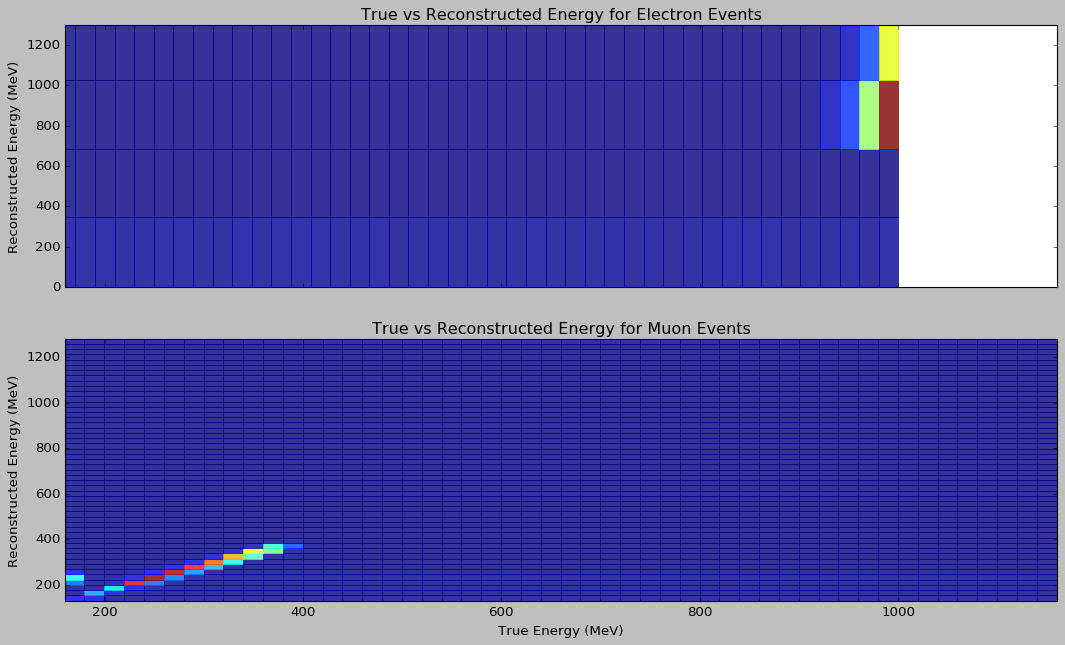

In [71]:
label_dict = {0:["gamma","red"], 1:["e","blue"], 2:["mu","green"]}

fig, axes = plt.subplots(2, 1, figsize=(16,9), sharex=True)

label = 0

axes[label].hist2d(e_energies[:,0], e_mom[:,0], weights=e_weights, bins=50, density=False, label=label_dict[label + 1][0], alpha=0.8)
#axes[label].legend()
axes[label].set_ylabel("Reconstructed Energy (MeV)")
axes[label].title.set_text('True vs Reconstructed Energy for Electron Events')

#axes[label].set_xlim([0, 1600])
axes[label].set_ylim([0, 1300])
plt.xlabel("True Energy (MeV)")


label = 1
axes[label].hist2d(mu_energies[:,0], mu_mom[:,1], weights=mu_weights, bins=50, density=False, label=label_dict[label + 1][0], alpha=0.8)
#axes[label].legend()
axes[label].set_ylabel("Reconstructed Energy (MeV)")
axes[label].title.set_text('True vs Reconstructed Energy for Muon Events')


plt.xlabel("True Energy (MeV)")


Text(0.5, 0, 'Energy (MeV)')

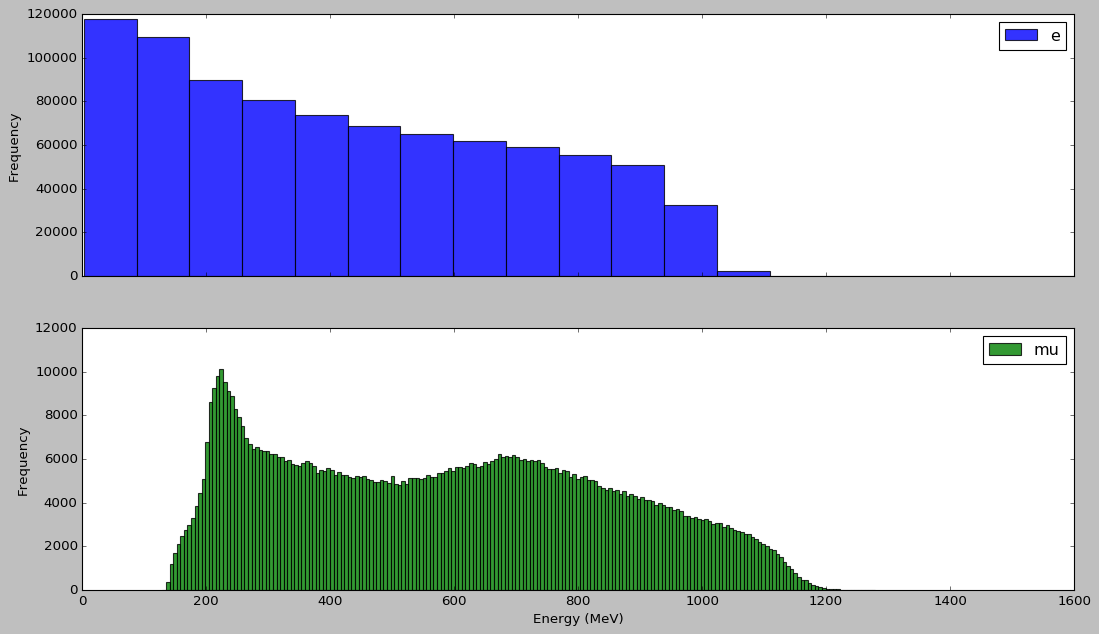

In [58]:
label_dict = {0:["gamma","red"], 1:["e","blue"], 2:["mu","green"]}


fig, axes = plt.subplots(2, 1, figsize=(16,9), sharex=True)

label = 0
axes[label].hist(e_mom[:,0], bins=200, density=False, label=label_dict[label + 1][0], alpha=0.8,
                 color=label_dict[label + 1][1])
axes[label].legend()
axes[label].set_ylabel("Frequency")

plt.xlabel("Energy (MeV)")

label = 1
axes[label].hist(mu_mom[:,1], bins=200, density=False, label=label_dict[label + 1][0], alpha=0.8,
                 color=label_dict[label + 1][1])
axes[label].legend()
axes[label].set_ylabel("Frequency")
plt.xlim(right=1600)
plt.xlabel("Energy (MeV)")


In [41]:
print(np.where(np.around(tprs[0], decimals=2) == 0.8)[0].shape)
eff_index = np.where(np.around(tprs[0], decimals=2) == 0.8)[0]
print(fprs[0][eff_index].mean())

a = np.array([[1,2,3,4],[5,6,7,8]])
print(a.shape)
print(np.sum(a,(0,1)))
print(np.sum(a > 0, 0))

(174,)
0.942899578897522
(2, 4)
36
[2 2 2 2]
